In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

## Result Gathering

In [2]:
main_df = None
directory = "Effort_Estimation_Results_v5_LargeProjectsSize/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Beam.csv
Camel.csv
Cxf.csv
Hadoop.csv


In [3]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken
0,1,19.859121,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,67,171,40.806862,3.5,1,6,1.870829,126,0.531746,1.595238
1,1,19.859121,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,123,123,NaN,1.0,1,1,NaN,409,0.300733,1.000000
2,1,19.859121,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,252,252,NaN,1.0,1,1,NaN,20,1.000000,86.000000
3,1,19.859121,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1550,1550,0.000000,4.0,3,5,1.414214,44,1.000000,4.000000
4,1,19.859121,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,12,12,NaN,11.0,11,11,NaN,884,0.013575,1.000000


In [4]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [5]:
len(main_df)

181

In [6]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='y_test')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='y_pred')
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

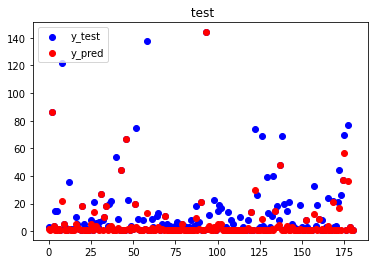

In [7]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],' test')

In [8]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [9]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



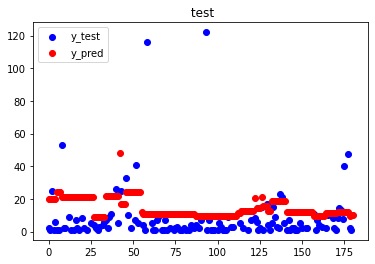

In [10]:
plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x1b92fb5f080>,
 'caps': [<matplotlib.lines.Line2D at 0x1b92fb5f748>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b92fb4eef0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b92fb5fe48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b92fb69240>],
 'means': []}

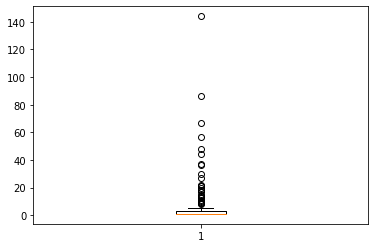

In [11]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [12]:
main_df = main_df[main_df['refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]

{'whiskers': [<matplotlib.lines.Line2D at 0x1b92fc059e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1b92fc130f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b92fc05898>],
 'medians': [<matplotlib.lines.Line2D at 0x1b92fc137f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b92fc13b70>],
 'means': []}

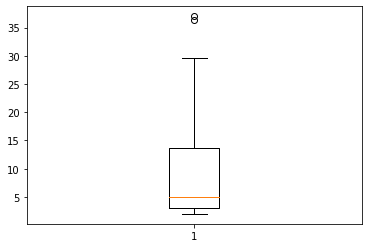

In [13]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [14]:
main_df = main_df[main_df['time_taken_final'] <= 60]
main_df = main_df[main_df['time_taken_final'] > 2]

In [15]:
main_df['time_taken_final'].value_counts()

7.0     7
5.0     4
9.0     3
4.0     2
8.0     2
11.0    2
3.0     2
41.0    1
6.0     1
8.6     1
4.1     1
15.0    1
10.0    1
7.4     1
14.4    1
47.4    1
8.8     1
53.0    1
Name: time_taken_final, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1b92fc69e48>,
 'caps': [<matplotlib.lines.Line2D at 0x1b92fc78550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b92fc69cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x1b92fc78c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b92fc78fd0>],
 'means': []}

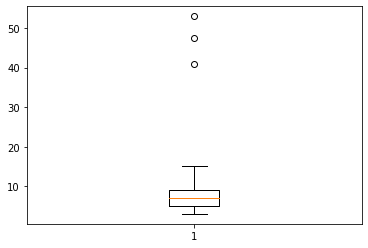

In [16]:
plt.boxplot(main_df['time_taken_final'])

In [17]:
main_df = main_df.fillna(0)

In [18]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,time_taken_final
8,4,21.150442,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,82,0.000000,7.000,7,7,0.000000,458,0.179039,21.842795,53.0
16,4,21.150442,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,113,0.000000,16.000,16,16,0.000000,222,0.509009,5.090090,7.0
20,4,21.150442,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,6,0.000000,1.500,1,2,0.707107,4,1.000000,18.000000,8.0
25,4,21.150442,1.0,167.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1091,0.000000,5.000,5,5,0.000000,1549,0.704325,5.634603,5.0
27,5,8.635449,1.0,166.0,1.0,1.0,1.0,1.0,2.0,3.0,...,2110,0.000000,32.000,31,33,1.414214,3171,0.665405,13.973510,4.1
31,8,8.655026,1.0,167.0,1.0,1.0,1.0,2.0,2.0,3.0,...,348,0.000000,2.000,2,2,0.000000,11,1.000000,27.000000,8.8
33,8,8.655026,1.0,167.0,1.0,1.0,1.0,2.0,2.0,3.0,...,2112,0.000000,1.000,1,1,0.000000,145,1.000000,10.000000,6.0
34,10,21.461919,1.0,167.0,1.0,2.0,2.0,2.0,4.0,6.0,...,52,0.000000,1.000,1,1,0.000000,49,1.000000,18.000000,7.0
36,10,21.461919,1.0,167.0,1.0,2.0,2.0,2.0,4.0,6.0,...,78,17.897858,6.500,1,12,5.802298,289,0.162630,3.252595,9.0
37,10,21.461919,1.0,167.0,1.0,2.0,2.0,2.0,4.0,6.0,...,1546,816.654333,5.400,1,11,4.393177,318,0.172956,3.805031,11.0


In [19]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [20]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [21]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [22]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [23]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [24]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [25]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
8,17.0,17.0,17.0,0.0,10.0,10.0,10.0,0.0,1.0,1.0,...,48.0,48.0,48.0,0.000000,1.0,1.0,1.0,0.0,37.0,82.0
16,14.0,14.0,14.0,0.0,11.0,11.0,11.0,0.0,1.0,1.0,...,77.0,77.0,77.0,0.000000,1.0,1.0,1.0,0.0,33.0,113.0
20,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,...,15.5,15.0,16.0,0.707107,1.0,1.0,1.0,0.0,17.5,6.0
25,23.0,23.0,23.0,0.0,6.0,6.0,6.0,0.0,12.0,12.0,...,498.0,498.0,498.0,0.000000,1.0,1.0,1.0,0.0,12.0,1091.0
27,131.0,131.0,131.0,0.0,161.0,161.0,161.0,0.0,9.0,9.0,...,390.0,390.0,390.0,0.000000,1.0,1.0,1.0,0.0,5.0,2110.0


In [26]:
y.head()

,refactoring_perc_time_taken
8,21.842795
16,5.090090
20,18.000000
25,5.634603
27,13.973510


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [28]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,38 mins 47 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 17 days !!!
H2O_cluster_name:,H2O_from_python_tanji_1m25f6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.981 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [29]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [31]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [32]:
aml = H2OAutoML(max_models=10, seed=16, exclude_algos=['XGBoost', 'GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
11:57:51.524: GBM_2_AutoML_20211220_115748 [GBM def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_2_AutoML_20211220_115748.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 18.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 18.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 18.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 19.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 19.0.

11:57:52.529: GBM_3_AutoML_20211220_115748 [GBM def_3] fai

In [33]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DeepLearning_grid__3_AutoML_20211220_115748_model_1,97.9753,9.89824,97.9753,7.36414,0.883506
StackedEnsemble_BestOfFamily_AutoML_20211220_115748,102.709,10.1346,102.709,7.78166,0.7616
StackedEnsemble_AllModels_AutoML_20211220_115748,124.007,11.1358,124.007,8.94697,0.863782
DeepLearning_grid__2_AutoML_20211220_115748_model_1,124.581,11.1616,124.581,8.56979,0.828215
DeepLearning_grid__2_AutoML_20211220_115748_model_2,136.045,11.6638,136.045,8.89748,nan
XRT_1_AutoML_20211220_115748,199.636,14.1293,199.636,11.3511,1.02399
DRF_1_AutoML_20211220_115748,213.336,14.606,213.336,11.576,1.0436
GBM_lr_annealing_selection__AutoML_20211220_115748_select_model,215.625,14.6842,215.625,11.4318,1.03
GBM_1_AutoML_20211220_115748,229.265,15.1415,229.265,11.9196,1.07948
DeepLearning_grid__1_AutoML_20211220_115748_model_1,625.977,25.0195,625.977,17.478,1.26642


In [34]:
model = h2o.get_model(lb[0,'model_id'])

In [35]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__3_AutoML_20211220_115748_model_1


Status of Neuron Layers: predicting refactoring_perc_time_taken, regression, gaussian distribution, Quadratic loss, 34,801 weights/biases, 435.7 KB, 197,110 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,144,Input,15,,,,,,,,,
1,,2,100,RectifierDropout,20,0,0,0.113065,0.0941127,0,0.00691841,0.102743,0.382512,0.0981704
2,,3,100,RectifierDropout,20,0,0,0.072956,0.0591071,0,-0.0225845,0.100774,0.892061,0.0636324
3,,4,100,RectifierDropout,20,0,0,0.0534531,0.0847535,0,-0.0297055,0.0977101,1.00144,0.0704352
4,,5,1,Linear,,0,0,0.00303817,0.00155978,0,0.0116097,0.076411,0.18724,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 2.105151806925441
RMSE: 1.4509141280328899
MAE: 1.2191201584376372
RMSLE: 0.2182272349036395
Mean Residual Deviance: 2.105151806925441

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 97.97525190815875
RMSE: 9.898244890290336
MAE: 7.364141640733074
RMSLE: 0.8835056605973725
Mean Residual Deviance: 97.97525190815875

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,7.4232125,1.9792453,8.198412,6.133021,6.579575,10.528373,5.6766806
1,mean_residual_deviance,97.149414,38.892273,133.54475,86.981285,89.916435,134.50163,40.802982
2,mse,97.149414,38.892273,133.54475,86.981285,89.916435,134.50163,40.802982
3,r2,-17.164854,37.657898,-0.4859222,0.42184073,0.25320593,-84.51573,-1.497668
4,residual_deviance,97.149414,38.892273,133.54475,86.981285,89.916435,134.50163,40.802982
5,rmse,9.6700325,2.1330373,11.556156,9.326376,9.482428,11.597484,6.387721
6,rmsle,0.8491516,0.30100974,1.1180222,0.47699153,0.7778294,1.1926814,0.6802334



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-20 12:00:27,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-12-20 12:00:27,47.531 sec,9583 obs/sec,10.0,1,230.0,7.220970,52.142402,6.014127,0.507933
2,,2021-12-20 12:00:32,52.546 sec,13752 obs/sec,3010.0,301,69230.0,1.170533,1.370147,1.019844,0.987070
3,,2021-12-20 12:00:37,57.554 sec,15559 obs/sec,6790.0,679,156170.0,1.376448,1.894609,1.174919,0.982121
4,,2021-12-20 12:00:39,59.890 sec,15937 obs/sec,8570.0,857,197110.0,1.450914,2.105152,1.219120,0.980134



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,lambdasQty_std,1.000000,1.000000,0.013733
1,parenthesizedExpsQty_min,0.864551,0.864551,0.011873
2,finalFields_std,0.799966,0.799966,0.010986
3,protectedMethods_min,0.781789,0.781789,0.010736
4,protectedMethods_mean,0.778774,0.778774,0.010695
5,protectedMethods_max,0.750090,0.750090,0.010301
6,dit_max,0.749370,0.749370,0.010291
7,dit_mean,0.734311,0.734311,0.010084
8,dit_min,0.727768,0.727768,0.009994
9,parenthesizedExpsQty_max,0.722453,0.722453,0.009921



See the whole table with table.as_data_frame()


In [36]:
preds = model.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [37]:
preds

predict
11.4615
17.0312
32.0775
5.17047
10.2973
4.56188
4.58615
5.75996
8.13445
6.57022


In [38]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

17.031207    1
32.077533    1
5.759965     1
5.170467     1
11.461535    1
10.297318    1
4.561883     1
6.570220     1
8.134452     1
4.586145     1
Name: predict, dtype: int64

In [39]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
17,17,17,0,10,10,10,0,1,1,1,0,11,11,11,0,16,16,16,0,8,8,8,0,0,0,0,0,5,5,5,0,1,1,1,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,83,83,83,0,7,7,7,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,4,4,4,0,1,1,1,0,5,5,5,0,1,1,1,0,4,4,4,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,48,48,48,0,1,1,1,0,37,82,21.8428
14,14,14,0,11,11,11,0,1,1,1,0,31,31,31,0,0,0,0,0,11,11,11,0,0,0,0,0,11,11,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,0,3,3,3,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,13,13,13,0,126,126,126,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,5,5,5,0,39,39,39,0,8,8,8,0,3,3,3,0,9,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,77,77,77,0,1,1,1,0,33,113,5.09009
2,2,2,0,1,1,1,0,4,4,4,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.5,15,16,0.707107,1,1,1,0,17.5,6,18
23,23,23,0,6,6,6,0,12,12,12,0,17,17,17,0,8,8,8,0,5,5,5,0,5,5,5,0,3,3,3,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,8,0,8,8,8,0,0,0,0,0,2,2,2,0,0,0,0,0,0

{'whiskers': [<matplotlib.lines.Line2D at 0x1b933415c18>,
 'caps': [<matplotlib.lines.Line2D at 0x1b93341f358>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b933415ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x1b93341fa58>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b93341fdd8>],
 'means': []}

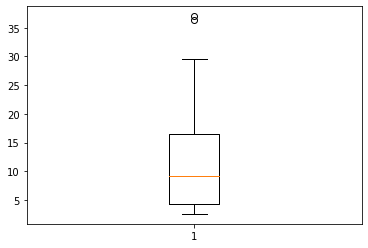

In [40]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

In [41]:
main_df['actual_num_of_classes_touched_max'].mean()

14.424242424242424

In [42]:
len(main_df['actual_num_of_classes_touched_max'])

33

In [43]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

33

In [44]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

33

In [45]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

31

In [46]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

25

In [47]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

17

{'whiskers': [<matplotlib.lines.Line2D at 0x1b933480860>,
 'caps': [<matplotlib.lines.Line2D at 0x1b933480f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b933480710>],
 'medians': [<matplotlib.lines.Line2D at 0x1b93348b630>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b93348b9b0>],
 'means': []}

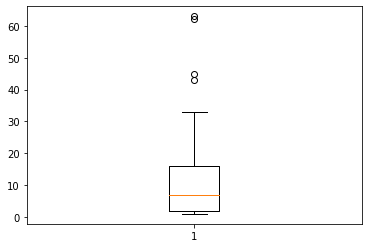

In [48]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [49]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x1b9334e7390>,
 'caps': [<matplotlib.lines.Line2D at 0x1b9334e7a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b9334e7240>],
 'medians': [<matplotlib.lines.Line2D at 0x1b9334f21d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b9334f2550>],
 'means': []}

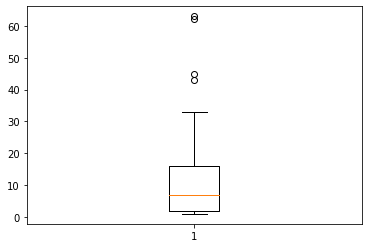

In [50]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b933544908>,
 'caps': [<matplotlib.lines.Line2D at 0x1b933550048>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b9335447b8>],
 'medians': [<matplotlib.lines.Line2D at 0x1b933550748>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b933550ac8>],
 'means': []}

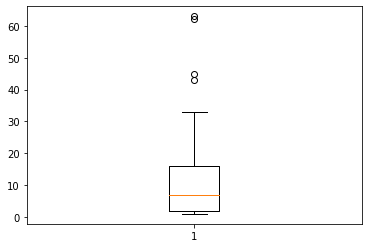

In [51]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [52]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [53]:
pd_preds

,predict,actual_time_taken
0,11.461535,27.000000
1,17.031207,18.000000
2,32.077533,20.000000
3,5.170467,2.205882
4,10.297318,21.000000
5,4.561883,4.067797
6,4.586145,14.000000
7,5.759965,12.617647
8,8.134452,4.035960
9,6.570220,16.708861


{'whiskers': [<matplotlib.lines.Line2D at 0x1b9335910f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b9335917b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b9335aff60>],
 'medians': [<matplotlib.lines.Line2D at 0x1b933591eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b9335c4278>],
 'means': []}

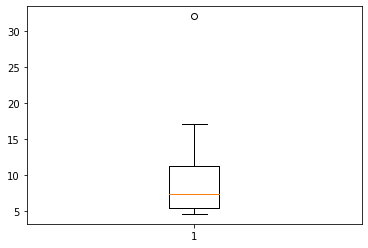

In [54]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b92f9dcd30>,
 'caps': [<matplotlib.lines.Line2D at 0x1b92fb24a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b92f9dcf60>],
 'medians': [<matplotlib.lines.Line2D at 0x1b92fb31278>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b92fb31940>],
 'means': []}

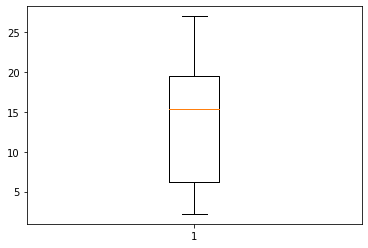

In [55]:
plt.boxplot(pd_preds['actual_time_taken'])

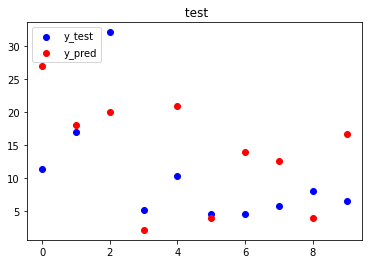

In [56]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],' test')

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

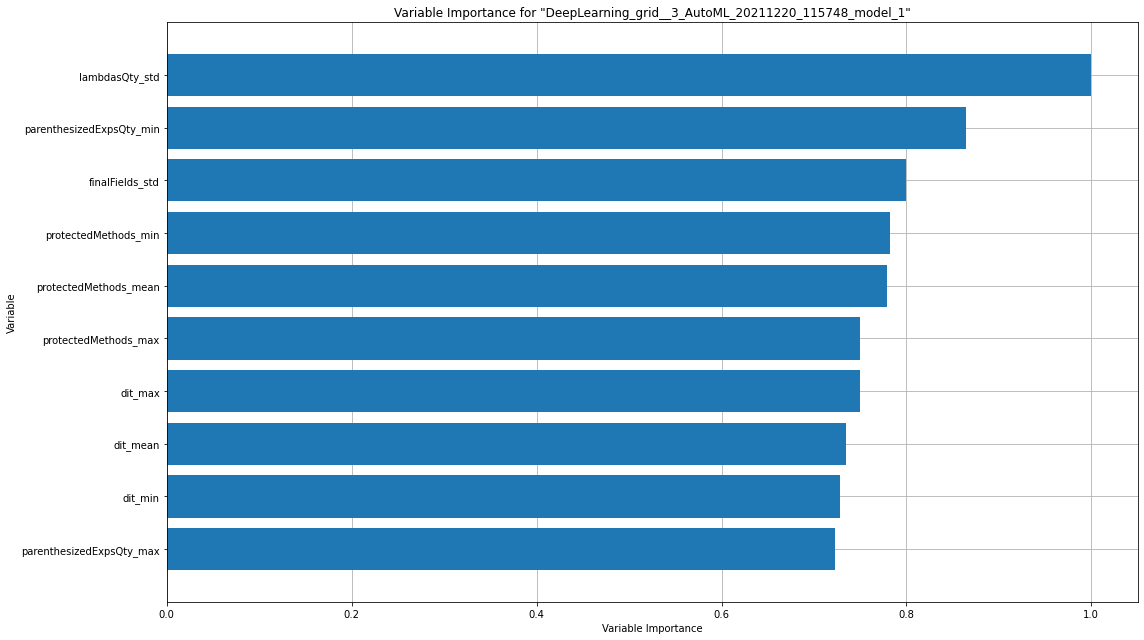

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\ProgramData\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


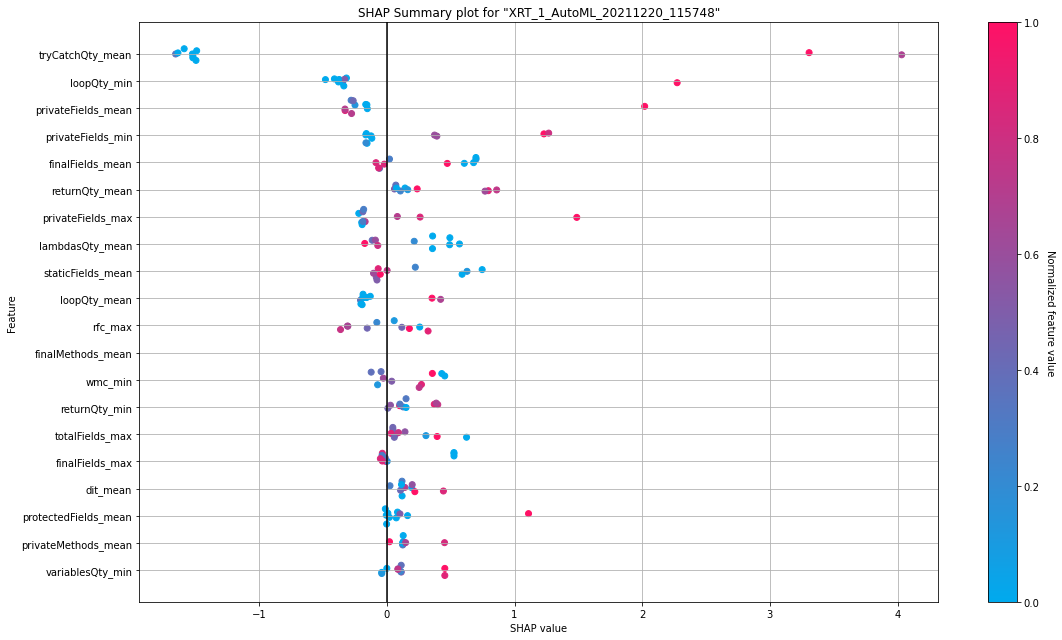

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

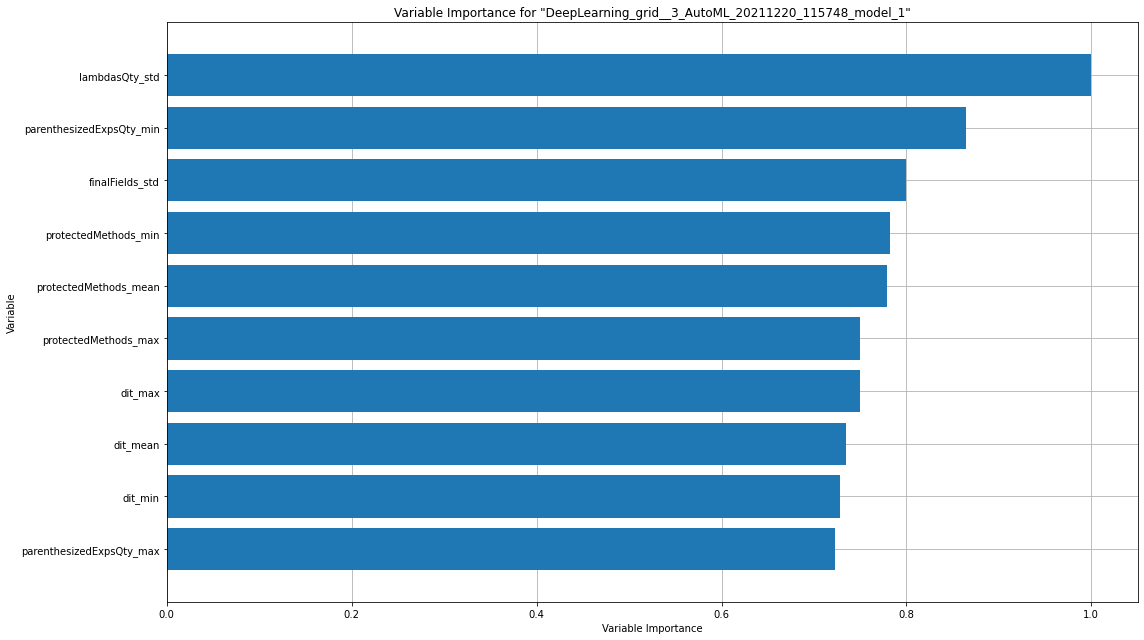

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

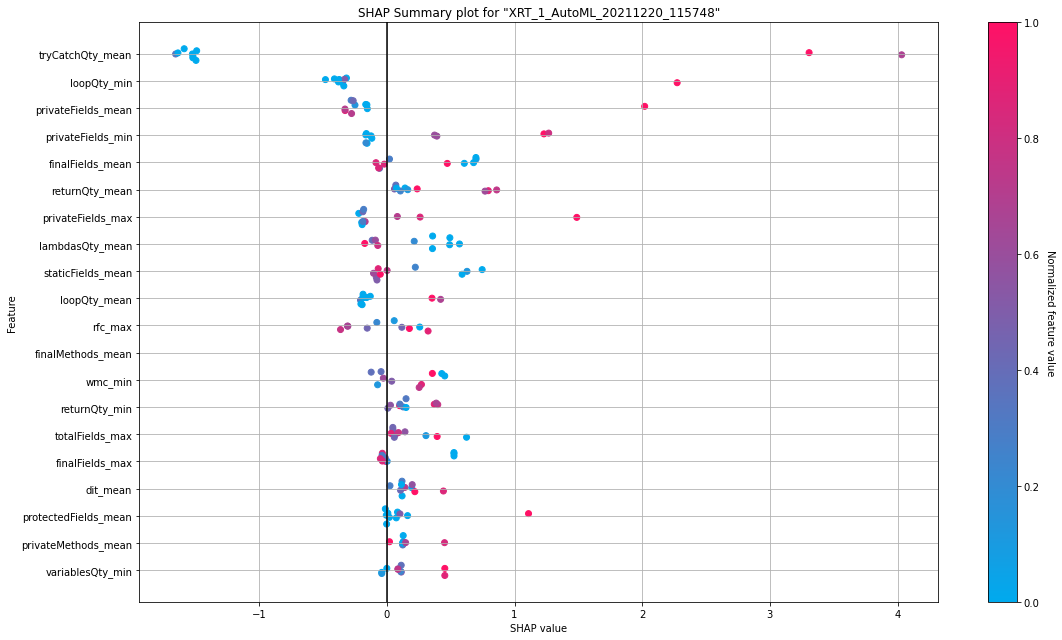

In [57]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [497]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

In [65]:
#aml.explain_row(test, row_index=0)

In [66]:
#h2o.shutdown()